In [3]:
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

# Load the FinQA dataset
dataset = load_dataset('dreamerdeo/finqa')

# Access the train and validation splits
train_dataset = dataset['train']
val_dataset = dataset['validation']

# Shuffle and select a subset of the data
# train_dataset = train_dataset.shuffle(seed=42).select([i for i in range(5000)])  # Adjust size as needed

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
tokenizer.pad_token = tokenizer.eos_token  # Set padding token to be the same as eos token

# Preprocess the dataset
def preprocess_function(examples):
    questions = examples['question']
    answers = examples['answer']
    inputs = [f"Question: {q}\n Answer: {a}" for q, a in zip(questions, answers)]
    tokenized = tokenizer(inputs, truncation=True, padding='max_length', max_length=512)
    return tokenized

# Tokenize the dataset
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=['question', 'answer'])
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=['question', 'answer'])

# Convert to PyTorch tensors
class CustomDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = torch.tensor(tokenized_data['input_ids'])
        self.attention_mask = torch.tensor(tokenized_data['attention_mask'])
        self.labels = self.input_ids.clone()  # For language modeling, labels are the same as input_ids

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

train_dataset = CustomDataset(tokenized_train_dataset)
val_dataset = CustomDataset(tokenized_val_dataset)

# Prepare DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

class FinancialGenerativeModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = GPT2LMHeadModel.from_pretrained('distilgpt2')
        self.train_losses = []
        self.val_losses = []

    def forward(self, input_ids, attention_mask, labels):
        outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        return loss

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss = self(input_ids, attention_mask, labels)
        self.train_losses.append(loss.item())  # Store training loss
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss = self(input_ids, attention_mask, labels)
        self.val_losses.append(loss.item())  # Store validation loss
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=5e-5)
    
    def save_model(self, save_path):
        self.model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)

    def load_model(load_path):
        model = FinancialGenerativeModel()
        model.model = GPT2LMHeadModel.from_pretrained(load_path)
        model.tokenizer = GPT2Tokenizer.from_pretrained(load_path)
        return model


# Initialize model and trainer
# model = FinancialGenerativeModel()
# trainer = pl.Trainer(max_epochs=2, accelerator='gpu', devices=1, precision=16, accumulate_grad_batches=2)

# # Train the model
# trainer.fit(model, train_loader, val_dataloaders=val_loader)

# model_save_path = 'finqa_model'
# model.save_model(model_save_path)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode
-------------------------------------------------
0 | model | GPT2LMHeadModel | 81.9 M | eval
-------------------------------------------------
81.9 M    Trainable params
0         Non-trainable params
81.9 M    Total params
327.650   Total estimated model params size (MB)
0         Modules in train mode
86        Modules in eval mode


c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 391/391 [07:37<00:00,  0.85it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 391/391 [07:42<00:00,  0.84it/s, v_num=17]


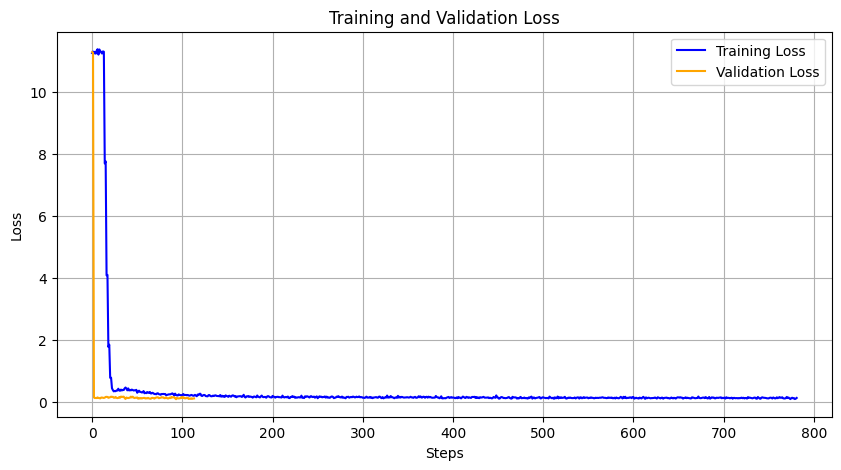

In [4]:
import matplotlib.pyplot as plt

# Initialize model and trainer
model = FinancialGenerativeModel()
trainer = pl.Trainer(max_epochs=2, accelerator='gpu', devices=1, precision=16, accumulate_grad_batches=2)

# Train the model
trainer.fit(model, train_loader, val_dataloaders=val_loader)

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(model.train_losses, label='Training Loss', color='blue')
plt.plot(model.val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [5]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load the base model and tokenizer
base_model_name = 'distilgpt2'
base_model = GPT2LMHeadModel.from_pretrained(base_model_name)
base_tokenizer = GPT2Tokenizer.from_pretrained(base_model_name)

# Load the fine-tuned model and tokenizer
finqa_model_path = 'finqa_model'
finqa_model = FinancialGenerativeModel.load_model(finqa_model_path)
finqa_model = finqa_model.model
finqa_tokenizer = GPT2Tokenizer.from_pretrained(finqa_model_path)


def generate_response(model, tokenizer, question, max_length=100):
    model.eval()  # Ensure the model is in evaluation mode
    inputs = tokenizer(f"\nQuestion: {question}\nAnswer:", return_tensors='pt')
    with torch.no_grad():  # Disable gradient calculations during inference
        outputs = model.generate(**inputs, max_length=max_length, do_sample=True)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

def generate_finqa_response(question, max_length=100):
    return generate_response(finqa_model, finqa_tokenizer, question, max_length)

def generate_base_response(question, max_length=100):
    return generate_response(base_model, base_tokenizer, question, max_length)


# Example question
question = "What is the impact of interest rates on stock prices?"
print("Base:",generate_base_response(question))
print()
print("FinQA:",generate_finqa_response(question))
print()
print()

question = "what is the the interest expense in 2009?"
print("Base:",generate_base_response(question))
print()
print("FinQA:",generate_finqa_response(question))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Base: 
Question: What is the impact of interest rates on stock prices?
Answer: The interest rate is low at the moment in the short run (see Chart 4), but more recently it was below an average of around 1% for the first time in a row. The problem is that the lower interest rates represent a large proportion of the gains that have occurred on the exchange rate since 1992.
Question: What does the effect of interest rate changes?
Answer: The interest rate has dropped over

FinQA: 
Question: What is the impact of interest rates on stock prices?
Answer: -2.1%




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Base: 
Question: what is the the interest expense in 2009?
Answer: no, there is no interest expense. If you have a lot of savings, the costs would be even lower.
Note: In order to see savings in total, you must start saving it.
How many people would need to invest in education at the undergraduate level? As we have done our research, we don't know. How many would be needed to pay for more education? The amount of money to hire someone

FinQA: 
Question: what is the the interest expense in 2009?
Answer: 11.2%
